In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, log_loss, confusion_matrix
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.utils import shuffle

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


## Dataset

In [2]:
train=pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv',index_col = 'Id')
test=pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col = 'Id')

In [3]:
imputer = KNNImputer()
data_to_impute = train.drop(columns = ['EJ', 'Class'], axis = 1)
data_imputed = imputer.fit_transform(data_to_impute)
data_imputed
data_imp = pd.DataFrame(data = data_imputed, index = data_to_impute.index, columns = data_to_impute.columns.to_list())
data1 = pd.concat([data_imp, train.EJ, train.Class], axis = 1)
# data1.isnull().sum()

In [4]:
data1.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,B,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,A,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,B,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,B,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,B,1


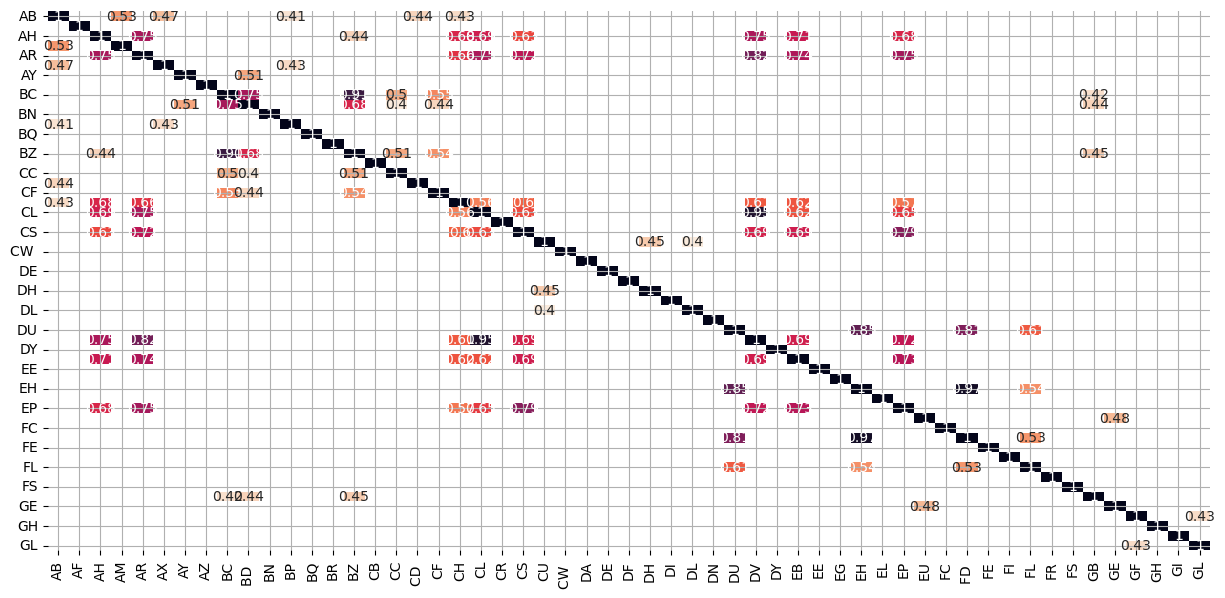

In [5]:
data_corr = data1.drop(columns = ['EJ', 'Class'], axis = 1)
corr_df = data_corr.corr()
corr_df = corr_df[(abs(corr_df)) >= 0.40]
plt.figure(figsize=(15,7))
sns.heatmap(corr_df, annot = True, cmap='rocket_r', cbar = False)
plt.grid()
plt.show()

## Pearson correlation

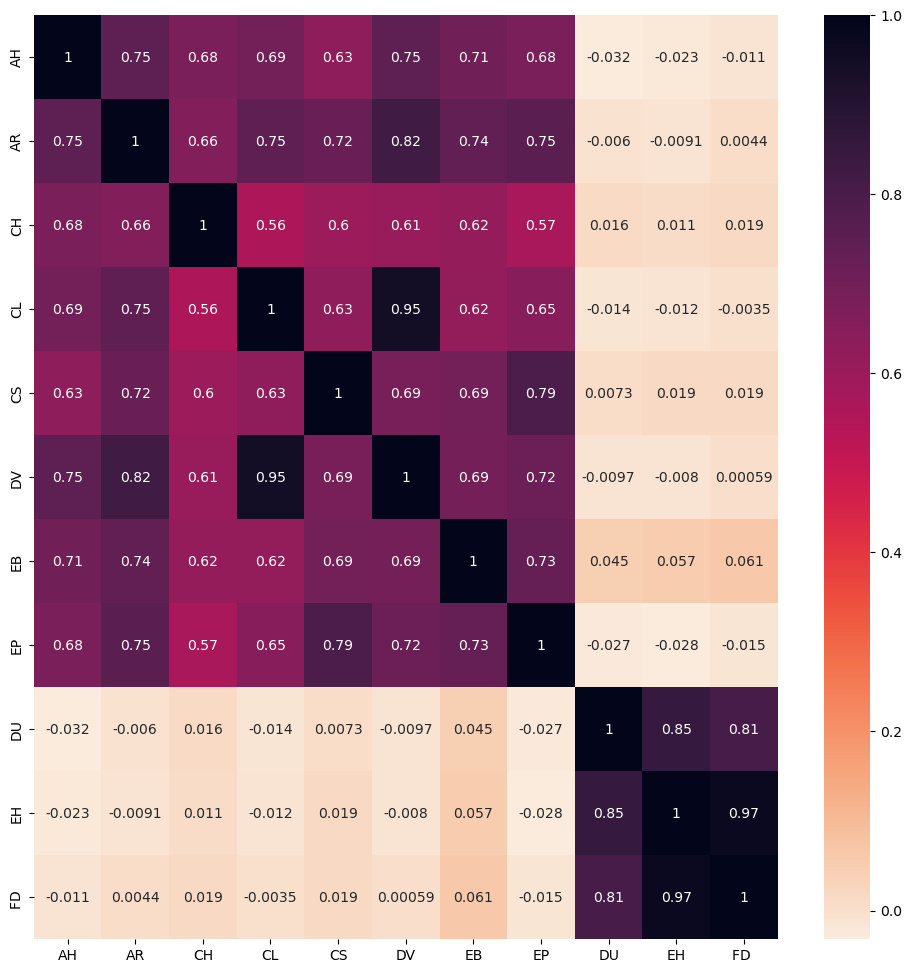

In [6]:
data_corr = data1.drop(columns = ['EJ', 'Class'], axis = 1)
corr_1st_cluster = data_corr[['AH', 'AR', 'CH', 'CL', 'CS', 'DV', 'EB', 'EP', 'DU', 'EH', 'FD ']]
corr_df = corr_1st_cluster.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_df, annot = True, cmap='rocket_r', cbar = True)
plt.show()

#### Use Anova test to get the important features

In [7]:
data_to_analyze = data1.drop('EJ', axis = 1) #we need to drop object variable for these tests
data_class_0 = data_to_analyze[data_to_analyze.Class == 0]
data_class_1 = data_to_analyze[data_to_analyze.Class == 1]

features_to_drop_Utest = []
features_to_drop_Htest = []
columns = data_to_analyze.columns.to_list()
columns.remove('Class')

for column in columns:
    U_rank, p_val1 = mannwhitneyu(data_class_0[column], data_class_1[column])
    if p_val1 > 0.05:
        features_to_drop_Utest.append(column)
        print(column, 'U rank:', U_rank, 'P value:', p_val1)
    H_rank, p_val2 = kruskal(data_class_0[column], data_class_1[column])
    if p_val2 > 0.05:
        features_to_drop_Htest.append(column)

#We need to compare the tests performance
features_to_drop_Htest == features_to_drop_Utest #Perfomance checking for the both tests

AH U rank: 28567.5 P value: 0.4585691165063628
AX U rank: 24896.5 P value: 0.12387252473131435
AY U rank: 29748.0 P value: 0.1042758173936365
AZ U rank: 26577.5 P value: 0.5891666444372265
BD  U rank: 28118.0 P value: 0.7074242520656782
BR U rank: 27889.5 P value: 0.8106634220534192
CB U rank: 28753.5 P value: 0.4512820352483915
CF U rank: 27832.0 P value: 0.8373050274357787
CH U rank: 27342.5 P value: 0.9322619817373052
CL U rank: 24861.5 P value: 0.0795676528595848
CS U rank: 29172.0 P value: 0.31646268472688366
CW  U rank: 30251.5 P value: 0.09534622073233975
DN U rank: 29316.0 P value: 0.27689441334062126
DY U rank: 24242.5 P value: 0.05392796919927672
EG U rank: 27423.0 P value: 0.9703690109171661
EL U rank: 24654.0 P value: 0.08193576667843223
EP U rank: 29751.5 P value: 0.14580032281606758
EU U rank: 25132.0 P value: 0.15867656516656026
FC U rank: 27190.0 P value: 0.8605895602308139
FS U rank: 26596.5 P value: 0.5922925334287551
GB U rank: 26190.0 P value: 0.44132864824650264
GE

True

In [8]:
print('Features to drop:', features_to_drop_Utest, '\n Quantity:', len(features_to_drop_Utest))

Features to drop: ['AH', 'AX', 'AY', 'AZ', 'BD ', 'BR', 'CB', 'CF', 'CH', 'CL', 'CS', 'CW ', 'DN', 'DY', 'EG', 'EL', 'EP', 'EU', 'FC', 'FS', 'GB', 'GE', 'GH', 'GI'] 
 Quantity: 24


In [9]:
#Anova

features_to_drop_ANOVA = []
columns = data_to_analyze.columns.to_list()
columns.remove('Class')

for column in columns:
    F, p_val = f_oneway(np.log1p(data_class_0[column]), np.log1p(data_class_1[column]))
    if p_val > 0.05:
        features_to_drop_ANOVA.append(column)
        print(column, 'F:', F, 'P value:', p_val)

#We need to compare the tests performance
features_to_drop_Utest == features_to_drop_ANOVA

AH F: 0.9028003294166651 P value: 0.34240518364921013
AX F: 3.288271989539755 P value: 0.07026373631825462
AY F: 2.3607184918846453 P value: 0.12493916238381524
AZ F: 0.0007053205100172908 P value: 0.9788209906464335
BD  F: 1.1080539539558618 P value: 0.2929187706196118
BR F: 0.14146444750050208 P value: 0.7069591819194481
CB F: 0.41946969660674166 P value: 0.517443469153401
CF F: 1.4361846527152875 P value: 0.2312193467137219
CH F: 0.05105979900145076 P value: 0.8213043745906105
CL F: 1.454548328693503 P value: 0.2282633010843752
CS F: 0.9389045055010414 P value: 0.3329406409464437
CW  F: 1.7219087512740827 P value: 0.1899370757777987
DN F: 0.9616555298034857 P value: 0.32715572514619407
DV F: 1.6772309566758525 P value: 0.1957787538047802
EG F: 0.00031332948627996063 P value: 0.9858830317986427
EL F: 2.6170012213169622 P value: 0.10623681173590564
EP F: 3.81197216618253 P value: 0.05134081654457645
EU F: 1.8232246979392093 P value: 0.17742659822745485
FC F: 0.022279175923753454 P val

False

In [10]:
features_to_drop_final = list(set(features_to_drop_Utest).intersection(set(features_to_drop_ANOVA)))

In [11]:
data1.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'EJ', 'Class'],
      dtype='object')

In [12]:
data1.drop(columns = features_to_drop_final, axis = 1, inplace = True)
data_object = data1.EJ
dummies_df = pd.get_dummies(data_object)
df_train = pd.concat([data1, dummies_df], axis = 1)
df_train.drop('EJ', axis = 1, inplace = True)
df_train

,AB,AF,AM,AR,BC,BN,BP,BQ,BZ,CC,...,FE,FI,FL,FR,GE,GF,GL,Class,A,B
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,22.394407,8.138688,5.555634,22.5984,175.638726,152.707705,257.432377,0.563481,...,9028.291921,3.583450,7.298162,1.73855,72.611063,2003.810319,0.120343,1,0,1
007255e47698,0.145282,978.76416,36.968889,8.138688,1.229900,19.4205,155.868030,14.754720,257.432377,0.484710,...,6785.003474,10.358927,0.173229,0.49706,72.611063,27981.562750,21.978000,0,1,0
013f2bd269f5,0.470030,2635.10654,32.360553,8.138688,1.229900,26.4825,128.988531,219.320160,257.432377,0.495852,...,8338.906181,11.626917,7.709560,0.97556,88.609437,13676.957810,0.196941,0,0,1
043ac50845d5,0.252107,3819.65177,77.112203,8.138688,1.229900,23.6577,237.282264,11.050410,257.432377,0.717882,...,10965.766040,14.852022,6.122162,0.49706,82.416803,2094.262452,0.155829,0,0,1
044fb8a146ec,0.380297,3733.04844,14.103738,8.138688,102.151980,24.0108,324.546318,149.717165,257.432377,0.536467,...,16198.049590,13.666727,8.153058,48.50134,146.109943,8524.370502,0.096614,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fd3dafe738fd,0.149555,3130.05946,9.513984,13.020852,2.804172,21.1860,167.877117,27.287375,257.432377,0.691257,...,17167.209610,9.879296,0.173229,1.26092,217.148554,8095.932828,21.978000,0,1,0
fd895603f071,0.435846,5462.03438,46.551007,15.973224,3.777550,27.1887,285.628059,344.644105,257.432377,0.772304,...,18460.330020,10.910227,10.223150,1.24236,496.994214,3085.308063,0.145340,0,0,1
fd8ef6377f76,0.427300,2459.10720,55.355778,10.005552,1.229900,20.4798,178.661133,103.988995,257.432377,0.708616,...,5088.922912,12.029366,0.173229,0.49706,128.896894,6474.652866,21.978000,0,1,0


In [13]:
X = df_train.drop('Class', axis = 1)
y = df_train.Class
X_shuffle, y_shuffle = shuffle(X, y, random_state = 3247)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 2312)

In [14]:
df_train.columns

Index(['AB', 'AF', 'AM', 'AR', 'BC', 'BN', 'BP', 'BQ', 'BZ', 'CC', 'CD ', 'CR',
       'CU', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DU', 'DV', 'DY', 'EB', 'EE',
       'EH', 'FD ', 'FE', 'FI', 'FL', 'FR', 'GE', 'GF', 'GL', 'Class', 'A',
       'B'],
      dtype='object')

### Use Xgboost classifier

In [15]:
estimator_XG = XGBClassifier(booster = 'gbtree', 
                             eval_metric = 'logloss',
                             tree_method = 'exact', 
                             random_state = 123, 
                             grow_policy = 'lossguide',
                             eta = 0,
                             learning_rate = 0.2, 
                             gamma = 0
                            )

params = {'n_estimators' : [110], 
          'max_depth' : [5],  
          'subsample' : [1.0],
          'scale_pos_weight' : [9], 
          'base_score' : [0.3],
          'colsample_bynode' : [0.3],
          'colsample_bytree' : [0.6],
          'colsample_bylevel' : [0.8]
         }

search_XG = GridSearchCV(estimator_XG, params, scoring = 'f1', cv = 4)
search_XG.fit(X_shuffle, y_shuffle)

print(search_XG.best_params_, '\n')
print('Best f1 score:', search_XG.best_score_, '\n')

{'base_score': 0.3, 'colsample_bylevel': 0.8, 'colsample_bynode': 0.3, 'colsample_bytree': 0.6, 'max_depth': 5, 'n_estimators': 110, 'scale_pos_weight': 9, 'subsample': 1.0} 

Best f1 score: 0.7868011526154525 



In [16]:
y_hat = cross_val_predict(search_XG.best_estimator_, X, y, cv = 4)
print('Accuracy:', round(accuracy_score(y, y_hat), 3), '\n')
print(classification_report(y, y_hat), '\n')
print(confusion_matrix(y, y_hat))

Accuracy: 0.927 

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       509
           1       0.79      0.80      0.79       108

    accuracy                           0.93       617
   macro avg       0.87      0.88      0.87       617
weighted avg       0.93      0.93      0.93       617
 

[[486  23]
 [ 22  86]]


In [17]:
acc_array = cross_val_score(search_XG.best_estimator_, X, y, scoring = 'accuracy', cv = 4)
print('Accuracies:', acc_array, '\n')
print('Mean accuracy:', round(acc_array.mean(), 3), 'Std deviation:', round(acc_array.std(), 3))

Accuracies: [0.93548387 0.92207792 0.91558442 0.93506494] 

Mean accuracy: 0.927 Std deviation: 0.009


In [18]:
probs = cross_val_predict(search_XG.best_estimator_, X, y, cv = 4, method = 'predict_proba')
prob_0_train = probs[:, 0]
prob_1_train = probs[:, 1]

In [19]:
def balanced_log_loss(y_true, y_pred, prob_0, prob_1):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_0 = prob_0
    p_1 = prob_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    balanced_log_loss = (w_0 * log_loss_0 + w_1 * log_loss_1) / 2
    # return the average log loss
    return balanced_log_loss

In [20]:
balanced_log_loss(y, y_hat, prob_0_train, prob_1_train)

0.3108375050400523

In [21]:
final_estimator = search_XG.best_estimator_
train_proba = cross_val_predict(final_estimator, X, y, cv = 4, method = 'predict_proba')

df_check = pd.DataFrame({
    #'Id' : X.index,
    'class_0' : train_proba[:, 0],
    'class_1' : train_proba[:, 1],
    'y_train' : y,
    'y_predicted' : y_hat
})
df_class_0 = df_check[['class_0', 'y_train', 'y_predicted']]
df_class_1 = df_check[['class_1', 'y_train', 'y_predicted']]

In [22]:
df_class_0.groupby(['y_train', 'y_predicted']).mean(),df_class_0.groupby(['y_train', 'y_predicted']).max()

(                      class_0
 y_train y_predicted          
 0       0            0.976192
         1            0.204644
 1       0            0.758168
         1            0.084731,
                       class_0
 y_train y_predicted          
 0       0            0.999956
         1            0.473876
 1       0            0.998841
         1            0.461716)

In [23]:
imputer = KNNImputer()
data_test_to_impute = test.drop(columns = 'EJ', axis = 1)
data_test_imputed = imputer.fit_transform(data_test_to_impute)
data_test_imp = pd.DataFrame(data = data_test_imputed, index = data_test_to_impute.index, columns = data_test_to_impute.columns.to_list())
data_test_1 = pd.concat([data_test_imp, test.EJ], axis = 1)
data_test_1.isnull().sum().sum()

0

In [24]:
features_to_drop_final

['CF',
 'CB',
 'EL',
 'BR',
 'FC',
 'CH',
 'AH',
 'EG',
 'AZ',
 'DN',
 'CS',
 'EP',
 'CL',
 'AY',
 'BD ',
 'EU',
 'CW ',
 'GI',
 'GH',
 'AX',
 'GB',
 'FS']

In [25]:
data_test_1=test[['AB', 'AF', 'AM', 'AR', 'BC', 'BN', 'BP', 'BQ', 'BZ', 'CC', 'CD ', 'CR',
       'CU', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DU', 'DV', 'DY', 'EB', 'EE',
       'EH', 'FD ', 'FE', 'FI', 'FL', 'FR', 'GE', 'GF', 'GL','EJ']]

In [26]:
# columns_to_drop_corr=[ 'DV', 'AR', 'EH', 'FD', 'BZ']
# # data_test_1.drop(columns = columns_to_drop_corr, axis = 1, inplace = True)        
# data_test_1.drop(columns = features_to_drop_final, axis = 1, inplace = True)
print(len(data_test_1.columns.to_list()))

data_test_1_object = data_test_1.EJ
dummies_df = pd.get_dummies(data_test_1_object)
df_test = pd.concat([data_test_1, dummies_df], axis = 1)
df_test.drop('EJ', axis = 1, inplace = True)
df_test

34


,AB,AF,AM,AR,BC,BN,BP,BQ,BZ,CC,...,EH,FD,FE,FI,FL,FR,GE,GF,GL,A
Id,,,,,,,,,,,,,,,,,,,,,
00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [27]:
df_test['B'] = np.abs(df_test['A'] - 1)
df_test.shape

(5, 35)

In [28]:
X_t = df_test
prob_predictions = final_estimator.predict_proba(X_t)
prob_predictions

array([[0.90183496, 0.09816502],
       [0.90183496, 0.09816502],
       [0.90183496, 0.09816502],
       [0.90183496, 0.09816502],
       [0.90183496, 0.09816502]], dtype=float32)

In [29]:
prob_0 = prob_predictions[:, 0]
prob_0

array([0.90183496, 0.90183496, 0.90183496, 0.90183496, 0.90183496],
      dtype=float32)

In [30]:
#thresholds are taken from Thresholds estimation
prob_0[prob_0 > 0.86] = 1
#prob_0[prob_0 < 0.12] = 0
prob_1 = 1 - prob_0
prob_1

array([0., 0., 0., 0., 0.], dtype=float32)

In [31]:
submission = pd.DataFrame({
    'Id' : X_t.index,
    'class_0' : prob_0,
    'class_1' : prob_1
})

In [32]:
submission.to_csv('submission.csv',  index = False)

In [33]:
#https://www.kaggle.com/code/pablo94/xgb-public-score-0-15